In [1]:
from multiprocessing import Pool
from tqdm import tqdm
from spacy.lang.en import English
import gensim.corpora as corpora
from gensim.models import LdaMulticore
import multiprocessing as mp

import re
import numpy as np
import pandas as pd
from pprint import pprint
import pickle
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from nltk.corpus import wordnet as wn
#nltk.download('stopwords')
#nltk.download('wordnet')
# spacy for lemmatization
import spacy
from spacy.lang.en import English
parser = English()

# Plotting tools

import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
num_cpus = mp.cpu_count() - 1

parser = English()

with open("../Data/tech_review_sent_corpus.pkl","rb") as f:
    tech_review_corpus = pickle.load(f)
    
reviews = pd.DataFrame(tech_review_corpus).review.tolist()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens


In [30]:
def compute_coherence_values(param):
    lda_model = LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=param["k"], 
                                           random_state=100,
                                           chunksize=1000,
                                           workers = num_cpus,
                                           passes=10,
                                           alpha=param["alpha"],
                                           eta=param["beta"],
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=id2word, coherence='c_v')
    
    param["coherence"] = coherence_model_lda.get_coherence()

    return param

if __name__ == "__main__":

    print("Total workers:", num_cpus)

    print("Tokenize the corpus")
    with Pool() as p:
        processed_docs = list(tqdm(p.imap(tokenize, reviews), total=len(reviews)))

    # Create Dictionary
    id2word = corpora.Dictionary(processed_docs)
    # Term Document Frequency
    print("Create a Dictionary")
    corpus = [id2word.doc2bow(text) for i, text in tqdm(enumerate(processed_docs), total=len(processed_docs))]

    grid = {}
    grid['Validation_Set'] = {}
    # Topics range
    min_topics = 5
    max_topics = 15
    step_size = 1
    topics_range = range(max_topics, min_topics, -1)
    # Alpha parameter
    alpha = list(np.arange(0.01, 1, 0.3))
    alpha.append('symmetric')
    alpha.append('asymmetric')
    # Beta parameter
    beta = list(np.arange(0.01, 1, 0.3))
    beta.append('symmetric')

    parameters = []
    for k in topics_range:
        for a in alpha:
            for b in beta:
                parameters.append({
                        "k":k
                        ,"alpha":a
                        ,"beta":b
                        ,"workers":4
                    })

    print("Running modeling")
    print("Total Paramters", len(parameters))

    results = list(map(compute_coherence_values, tqdm(parameters)))
    
    df = pd.DataFrame(results).to_csv("../Data/lda_sent_modeling.csv",index = False)

Total workers: 15
Tokenize the corpus


  8%|▊         | 12715/156991 [00:00<00:01, 127076.50it/s]

Create a Dictionary


  0%|          | 0/60 [00:00<?, ?it/s]

Running modeling
Total Paramters 60


100%|██████████| 60/60 [1:10:27<00:00, 70.46s/it]


In [33]:
pd.read_csv('lda_sent_modeling.csv').sort_values(by = ['coherence','k'],ascending=False)

,k,alpha,beta,workers,coherence
298,6,asymmetric,0.91,4,0.475331
237,8,asymmetric,0.61,4,0.456776
28,15,asymmetric,0.91,4,0.456197
232,8,symmetric,0.61,4,0.446326
88,13,asymmetric,0.91,4,0.444676
...,...,...,...,...,...
286,6,0.91,0.31,4,0.326012
287,6,0.91,0.61,4,0.325265
288,6,0.91,0.91,4,0.324374
289,6,0.91,symmetric,4,0.322756


In [14]:
final_lda_model = LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           chunksize=1000,
                                           workers = 4,
                                           passes=10,
                                           alpha='asymmetric',
                                           eta=0.61,
                                           per_word_topics=True)

In [15]:
# Select the model and print the topics
optimal_model = final_lda_model
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

[(0,
  '0.136*"work" + 0.053*"great" + 0.030*"people" + 0.027*"environment" + '
  '0.026*"part" + 0.026*"job" + 0.023*"enjoy" + 0.021*"place" + '
  '0.019*"management" + 0.016*"worker" + 0.016*"co" + 0.015*"friendly" + '
  '0.014*"fun" + 0.012*"time" + 0.012*"culture" + 0.010*"manager" + '
  '0.010*"really" + 0.009*"hardest" + 0.008*"always" + 0.008*"supportive"'),
 (1,
  '0.044*"life" + 0.042*"work" + 0.034*"balance" + 0.033*"employee" + '
  '0.025*"benefit" + 0.022*"management" + 0.017*"job" + 0.017*"salary" + '
  '0.014*"pay" + 0.011*"le" + 0.010*"long" + 0.010*"care" + 0.010*"security" + '
  '0.009*"level" + 0.008*"hour" + 0.007*"high" + 0.007*"company" + '
  '0.007*"policy" + 0.007*"much" + 0.006*"compensation"'),
 (2,
  '0.115*"learn" + 0.058*"lot" + 0.047*"work" + 0.047*"project" + '
  '0.042*"technology" + 0.033*"year" + 0.031*"thing" + 0.024*"many" + '
  '0.018*"different" + 0.015*"experience" + 0.015*"got" + 0.011*"get" + '
  '0.010*"2" + 0.009*"3" + 0.009*"knowledge" + 0.008

In [16]:
lda_display = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

In [17]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=reviews):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=final_lda_model, corpus=corpus, texts=reviews)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()

df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

#df_dominant_topic["Review"] = reviews_["review"] 
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.7030,"work, great, people, environment, part, job, e...",great people care make difference
1,1,1.0,0.4470,"life, work, balance, employee, benefit, manage...",management care employee well providing contin...
2,2,5.0,0.5735,"manager, get, management, time, would, job, ma...",powerhouse epc went heavy worksharing
3,3,5.0,0.6568,"manager, get, management, time, would, job, ma...",send much work overseas possible keep core person
4,4,1.0,0.7913,"life, work, balance, employee, benefit, manage...",heavy loaded management
5,5,2.0,0.5553,"learn, lot, work, project, technology, year, t...",chase project hire thousand oil booming
6,6,5.0,0.8170,"manager, get, management, time, would, job, ma...",turn lay thousand going
7,7,5.0,0.8094,"manager, get, management, time, would, job, ma...",sharpest spike hiring laying
8,8,0.0,0.3927,"work, great, people, environment, part, job, e...",employee clearly great asset
9,9,5.0,0.7698,"manager, get, management, time, would, job, ma...",much could add


In [18]:
with open("../Data/all_reviews.pkl","rb") as f:
    reviews_ = pickle.load(f)
    
job_filter = pd.read_csv("../Data/filter_job_titles.csv")

job_filters = job_filter.clean_job_title.tolist()
idx = (reviews_.language == "en")
reviews_ = reviews_.loc[idx,:]

idx = (reviews_.clean_job_title.isin(job_filters))
reviews_ = reviews_.loc[idx,:].reset_index()

print(reviews_.shape)

(45251, 16)


In [19]:
df_sent = pd.DataFrame(pd.DataFrame(tech_review_corpus).groupby('index'))
df_sent.columns=['Indexes','reviews']
display(df_sent.head(10))

,Indexes,reviews
0,299,index ...
1,1145,index ...
2,1375,index review 9 ...
3,1874,index ...
4,2136,index ...
5,2209,index ...
6,2685,index ...
7,3054,index rev...
8,3082,index ...
9,3134,index ...


In [20]:
sent_corpus= pd.DataFrame(tech_review_corpus)

In [21]:
sent_corpus

,index,review
0,299,great people care make difference
1,299,management care employee well providing contin...
2,1145,powerhouse epc went heavy worksharing
3,1145,send much work overseas possible keep core person
4,1145,heavy loaded management
...,...,...
156986,2587643,enjoy teamwork
156987,2587648,work reporting make sure everyone work
156988,2587648,processed claim
156989,2587648,enjoy work processor


In [22]:
df_dominant_topic['Index'] = sent_corpus['index']
index_list = list(set(df_dominant_topic["Index"].values))
df_dominant_topic.head(10)
reviews_.review.loc[df_sent[df_sent["Indexes"] == [i for i in index_list]].index]

36301    oracle dba ,i am working here from past 7 yrs ...
Name: review, dtype: object

In [23]:
index_list = list(set(df_dominant_topic["Index"].values))
index_list.sort(reverse=False)
df_dominant_topic_copy = df_dominant_topic.copy()

In [66]:
Review_List = []
for i in index_list:
    if [item for item in (df_dominant_topic.Index.isin([i]).values)]:
        sent_idx = df_dominant_topic['Index'].loc[df_dominant_topic[df_dominant_topic["Index"] == i].index].index
        for x in range(len(sent_idx)):
            Review_List.append(reviews_.review.loc[df_sent[df_sent["Indexes"] == i].index].tolist()[0])
           

In [67]:
df_dominant_topic_copy = df_dominant_topic_copy.assign(Review=Review_List)

In [68]:
df_dominant_topic_copy.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Index,Review
0,0,0.0,0.7030,"work, great, people, environment, part, job, e...",great people care make difference,299,Fluor is a great company with people that care...
1,1,1.0,0.4470,"life, work, balance, employee, benefit, manage...",management care employee well providing contin...,299,Fluor is a great company with people that care...
2,2,5.0,0.5735,"manager, get, management, time, would, job, ma...",powerhouse epc went heavy worksharing,1145,Fluor was the first powerhouse EPC that went h...
3,3,5.0,0.6568,"manager, get, management, time, would, job, ma...",send much work overseas possible keep core person,1145,Fluor was the first powerhouse EPC that went h...
4,4,1.0,0.7913,"life, work, balance, employee, benefit, manage...",heavy loaded management,1145,Fluor was the first powerhouse EPC that went h...
5,5,2.0,0.5553,"learn, lot, work, project, technology, year, t...",chase project hire thousand oil booming,1145,Fluor was the first powerhouse EPC that went h...
6,6,5.0,0.8170,"manager, get, management, time, would, job, ma...",turn lay thousand going,1145,Fluor was the first powerhouse EPC that went h...
7,7,5.0,0.8094,"manager, get, management, time, would, job, ma...",sharpest spike hiring laying,1145,Fluor was the first powerhouse EPC that went h...
8,8,0.0,0.3927,"work, great, people, environment, part, job, e...",employee clearly great asset,1145,Fluor was the first powerhouse EPC that went h...
9,9,5.0,0.7698,"manager, get, management, time, would, job, ma...",much could add,1375,There is not much that I could add here. I en...


In [69]:
with open("topic_sent_reviews.pkl","wb") as f:
    pickle.dump(df_dominant_topic_copy,f)

### Sklearn Topic Modeling

In [3]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV 

In [4]:
vectorizer = CountVectorizer(min_df=3, token_pattern='[a-zA-Z0-9]{3,}',ngram_range=(1,1))
data_vectorized = vectorizer.fit_transform(reviews)

In [5]:
data_vectorized.get_shape()

(156991, 9139)

In [6]:
# Define dictionaries for models and hyperparameters to be used in grid search evaluation:
lda = LatentDirichletAllocation(learning_method="online", verbose=1,random_state=100)
           

ParamDict = {"n_components": [7,8,9,10,11,12,13,14,15]
                     , "learning_decay": [.5, .7, .9]
                    }
                                    
gs = GridSearchCV(lda, ParamDict, cv=3, n_jobs=-1,
                              return_train_score='warn',pre_dispatch='2*n_jobs', refit=True
                              , verbose=1)
gs.fit(data_vectorized)



Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 35.6min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 83.1min finished


iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


GridSearchCV(cv=3, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1, random_state=100,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
                               

In [7]:
# Best Model
best_lda_model = gs.best_estimator_
# Model Parameters
print("Best Model's Params for: ", gs.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", gs.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))  


Best Model's Params for:  {'learning_decay': 0.9, 'n_components': 7}
Best Log Likelihood Score:  -2270411.4839993347
Model Perplexity:  1177.1833963666077


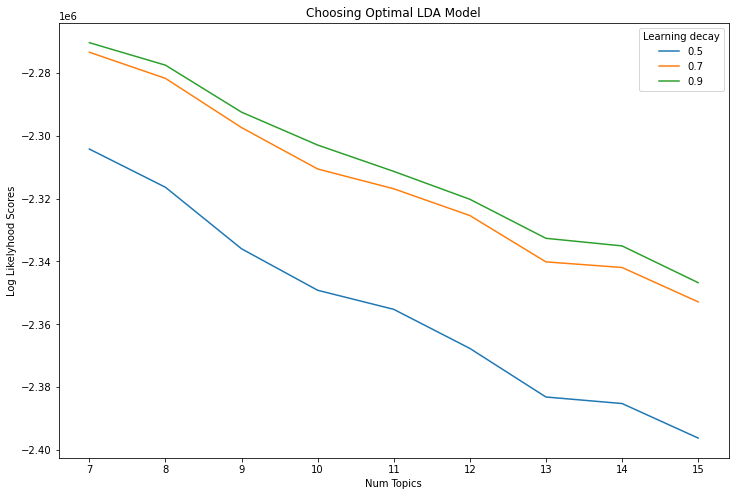

In [8]:
# Get Log Likelyhoods from Grid Search Output: Higher the better
n_topics = [7,8,9,10,11,12,13,14,15]
log_likelyhoods_5 = [round(i) for i in gs.cv_results_['mean_test_score'][0:9]]
log_likelyhoods_7 = [round(i) for i in gs.cv_results_['mean_test_score'][9:18]]
log_likelyhoods_9 = [round(i) for i in gs.cv_results_['mean_test_score'][18:27]]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [9]:
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
 
print("LDA Model:")
print_topics(best_lda_model, vectorizer)
print("=" * 20)

LDA Model:
Topic 0:
[('skill', 3764.1724218525273), ('time', 3195.789785106465), ('worked', 2785.597029960156), ('year', 2651.3066606975535), ('salary', 2228.3733453434174), ('got', 2058.062488342733), ('knowledge', 1998.7937966979016), ('software', 1750.0793639414949), ('technical', 1746.6017835029547), ('organization', 1491.2638298797572)]
Topic 1:
[('job', 6372.519805969343), ('part', 5869.716182235384), ('work', 5707.399698038054), ('working', 4026.1040978518854), ('one', 3964.0365494793527), ('support', 3353.00065940792), ('time', 2916.5307430124963), ('also', 2794.341085255932), ('service', 2336.406133681296), ('project', 2304.156111680218)]
Topic 2:
[('friendly', 3369.3782976856332), ('development', 2057.4203443845136), ('fresher', 1975.3589129196282), ('project', 1868.7458000323556), ('process', 1635.9874645464186), ('much', 1629.8963407169065), ('management', 1591.718455485679), ('professional', 1429.5502396516365), ('year', 1262.751801802096), ('end', 1181.9407957661263)]
Top

In [10]:
# Build a Non-Negative Matrix Factorization Model
nmf_model = NMF(n_components=7,init='nndsvd')
nmf_word = nmf_model.fit_transform(data_vectorized)
print(nmf_word.shape)  # (NO_DOCUMENTS, NO_TOPICS)

print(nmf_word[0])


(156991, 7)
[0.         0.         0.07478795 0.00294493 0.1047207  0.00259501
 0.00464615]


In [11]:

 
print("NMF Model:")
print_topics(nmf_model, vectorizer)
print("=" * 20)
 


NMF Model:
Topic 0:
[('work', 16.750807959546655), ('life', 2.5641133092227193), ('balance', 2.288518402532793), ('place', 1.6230197659503731), ('culture', 1.2962316730343222), ('environment', 1.0467443922327666), ('nice', 0.7388114599016932), ('fun', 0.5426923641558884), ('home', 0.3904809858107552), ('hour', 0.37148416927337885)]
Topic 1:
[('good', 13.211722010989353), ('culture', 0.923434175558038), ('place', 0.8001536300866356), ('environment', 0.5843123148194957), ('learning', 0.49571737358532025), ('life', 0.4936225880494207), ('benefit', 0.4928401053613968), ('balance', 0.48296299905272305), ('salary', 0.4185102323439577), ('experience', 0.3959086265435082)]
Topic 2:
[('company', 13.386550859298211), ('employee', 1.3310692981419647), ('one', 0.6047112239654335), ('year', 0.4112843264691063), ('service', 0.37654313667426703), ('like', 0.3406521775708053), ('worked', 0.3099521128030675), ('start', 0.27531305368305625), ('would', 0.2533519541749798), ('benefit', 0.2490271259267602)

### bigram model

In [4]:
bigram_vectorizer = CountVectorizer(min_df=3, token_pattern='[a-zA-Z0-9]{3,}',ngram_range=(2,2))
data_bigram_vectorized = bigram_vectorizer.fit_transform(reviews)

In [5]:
data_bigram_vectorized.get_shape()

(156991, 42742)

In [6]:
# Define dictionaries for models and hyperparameters to be used in grid search evaluation:
lda = LatentDirichletAllocation(learning_method="online", verbose=1,random_state=100)
           

ParamDict = {"n_components": [7,8,9,10,11,12,13,14,15]
                     , "learning_decay": [.5, .7, .9]
                    }
                                    
gs = GridSearchCV(lda, ParamDict, cv=3, n_jobs=-1,
                              return_train_score='warn',pre_dispatch='2*n_jobs', refit=True
                              , verbose=1)
gs.fit(data_bigram_vectorized)



Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 122.0min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 282.7min finished


iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


GridSearchCV(cv=3, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1, random_state=100,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
                               

In [8]:
# Best Model
best_lda_model = gs.best_estimator_
# Model Parameters
print("Best Model's Params for: ", gs.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", gs.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_bigram_vectorized))  


Best Model's Params for:  {'learning_decay': 0.9, 'n_components': 7}
Best Log Likelihood Score:  -1706384.611770412
Model Perplexity:  19318.40661838415


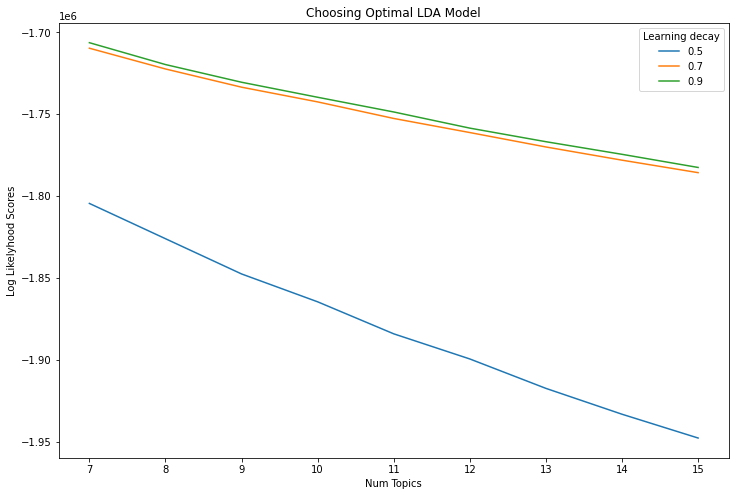

In [9]:
# Get Log Likelyhoods from Grid Search Output: Higher the better
n_topics = [7,8,9,10,11,12,13,14,15]
log_likelyhoods_5 = [round(i) for i in gs.cv_results_['mean_test_score'][0:9]]
log_likelyhoods_7 = [round(i) for i in gs.cv_results_['mean_test_score'][9:18]]
log_likelyhoods_9 = [round(i) for i in gs.cv_results_['mean_test_score'][18:27]]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [11]:
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
 
print("LDA Model:")
print_topics(best_lda_model, bigram_vectorizer)
print("=" * 20)

LDA Model:
Topic 0:
[('work environment', 1735.655608419259), ('management good', 1182.5541989895307), ('work place', 867.8849312215062), ('enjoyed working', 641.75589786181), ('learning experience', 467.9568531324643), ('employee friendly', 405.8522423145158), ('nice work', 321.69749181525435), ('call center', 283.7876987465294), ('get work', 272.4475721949743), ('work done', 256.90351757579833)]
Topic 1:
[('work life', 5097.456656390411), ('life balance', 4772.671921817456), ('good work', 3397.199148421353), ('good place', 2710.338028057913), ('good management', 921.7982423570652), ('place learn', 727.1211079843089), ('learn technology', 703.2845370856882), ('work good', 692.6107166761955), ('balance good', 670.6306800026906), ('good learning', 630.6615257854487)]
Topic 2:
[('part job', 2646.882906610372), ('hardest part', 1967.0830839098448), ('enjoyable part', 1614.3620145765374), ('learned lot', 1212.168466085878), ('typical work', 806.2316270920489), ('workplace culture', 623.074